In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm, truncnorm, gennorm

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from Aux import create_nn_per_layer, sample_from_GP

def set_ax_lims(ax, ylabel=True):
    ax.set_xlim([-1, 1])
    ax.set_ylim([-2.5, 2.5])
    ax.set_xlabel('$X$', fontsize=14)
    if ylabel:
        ax.set_ylabel('$Y$', fontsize=14)
    ax.grid(True)
    

In [2]:
# Set some properties of the neural network we will train
layers_shape = (50, 50, 50, 50)
act = lambda features: tf.nn.leaky_relu(features, alpha=0.01)     # tf.nn.tanh
optimizer=Adam(learning_rate=0.001)

tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
init_weights_for_all = tmp_model.get_weights()


In [3]:
print(np.sum([w_.size for w_ in init_weights_for_all]))

7801


## Prior

In [4]:
def sample_from_mean_plus_GP(xvals, k0, L, mean_func):
    mean_ = mean_func(xvals)
    return mean_ + sample_from_GP(xvals, k0=k0, L=L)

def sample_prior_set_norm(n_prior=400):
    x_values = truncnorm(a=-2, b=2).ppf(LatinHypercube(d=1).random(n_prior)).reshape((-1, 1))
    return x_values
    
#def sample_prior_set_unif():
#    x_values = -np.sqrt(3)+2*np.sqrt(3)*LatinHypercube(d=1).random(500).reshape((-1, 1))
#    return x_values

In [5]:
a=LatinHypercube(d=2).random(200)
print(a.shape)

(200, 2)


In [6]:
prior_names = ['A', 'B', 'C', 'D']

def evaluate_prior_lin(x_values, k0, L):
    y_prior = sample_from_mean_plus_GP(x_values, k0=k0, L=L, mean_func=lambda x: 2*x)
    return y_prior

def evaluate_prior_cub(x_values, k0, L):
    y_prior = sample_from_mean_plus_GP(x_values, k0=k0, L=L, mean_func=lambda x: 5*(-1+2*np.random.rand()) * x**3)
    return y_prior

priorA = lambda x: evaluate_prior_lin(x, k0=0.6, L=0.8)
priorB = lambda x: evaluate_prior_lin(x, k0=0.6, L=0.2)
priorC = lambda x: evaluate_prior_lin(x, k0=0.6, L=0.05)
priorD = lambda x: evaluate_prior_cub(x, k0=0.1, L=0.2)
all_prior_funcs = [priorA, priorB, priorC, priorD]

all_epochs = [100, 200, 2000, 250]

def set_some_stuff_prior(ax):
    for i in range(4):
        ax[i].set_xlim([-1, 1])
        ax[i].set_ylim([-4, 4])
        ax[i].set_yticks([-4, -2, 0, 2, 4])
        ax[i].set_title('Prior {}'.format(prior_names[i]))
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('Y')
    return ax


In [7]:
import pickle
with open('priors_073024_N[200].pkl', 'rb') as handle:
    dict_results = pickle.load(handle)
x_test = dict_results['x_test']
all_ws_v0, preds_v0, losses_v0 = dict_results['prior_A']
all_ws_v1, preds_v1, losses_v1 = dict_results['prior_B']
all_ws_v2, preds_v2, losses_v2 = dict_results['prior_C']
all_ws_v3, preds_v3, losses_v3 = dict_results['prior_D']

n_ens_to_keep = 100
all_ws_v0 = [w_[:n_ens_to_keep] for w_ in all_ws_v0]
all_ws_v1 = [w_[:n_ens_to_keep] for w_ in all_ws_v1]
all_ws_v2 = [w_[:n_ens_to_keep] for w_ in all_ws_v2]
all_ws_v3 = [w_[:n_ens_to_keep] for w_ in all_ws_v3]

print(all_ws_v0[2].shape)

(100, 2500)


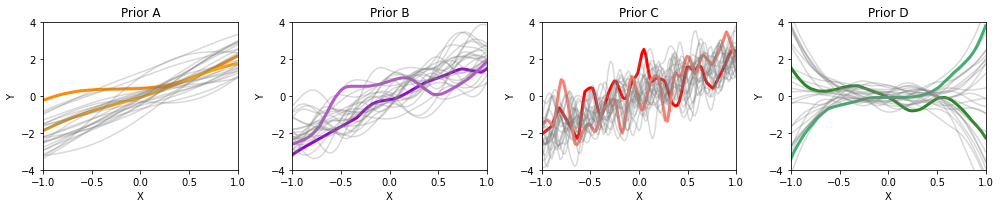

In [8]:
colors = [['darkorange', 'darkviolet', 'red', 'forestgreen'], 
          ['orange', 'mediumorchid', 'salmon', 'mediumseagreen']]

tmp_model = create_nn_per_layer(
    layers_shape=layers_shape, act=act, lmda_reg=0., optimizer=optimizer)
init_weights_for_all = tmp_model.get_weights()

fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
losses = [[], [], [], []]
for i, (evaluate_prior, preds) in enumerate(zip(all_prior_funcs, [preds_v0, preds_v1, preds_v2, preds_v3])):
    for j in range(25):
        x_values = sample_prior_set_norm(200)
        y_prior = evaluate_prior(x_values)
        sort_idx = np.argsort(x_values[:, 0])
        ax[i].plot(x_values[sort_idx, 0], y_prior[sort_idx, 0], color='gray', alpha=0.3)
        if j < 2:
            y_prior, y_pred = preds[j]
            ax[i].plot(x_test, y_pred, alpha=1, color=colors[j][i], label='fitted NN', linewidth=3)

set_some_stuff_prior(ax)
fig.tight_layout()
plt.show(fig)

#fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
#for i in range(4):
#    for l_ in losses[i]:
#        ax[i].plot(l_)
#    ax[i].grid(True)
#    ax[i].set_yscale('log')
#fig.tight_layout()
#plt.show(fig)


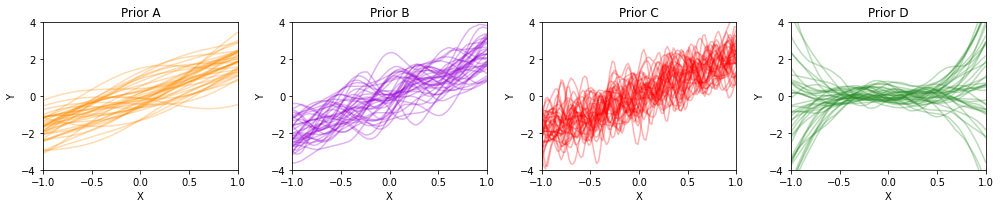

In [9]:
prior_colors = ['darkorange', 'darkviolet', 'red', 'forestgreen']

# From trained NNs
fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
for i, preds in enumerate([preds_v0, preds_v1, preds_v2, preds_v3]):
    for pred in preds[:40]:
        y_prior, y_pred = pred
        #ax[i].plot(x_test, y_prior, color='black', alpha=0.8)
        ax[i].plot(x_test, y_pred, color=prior_colors[i], alpha=0.3, label='fitted NN')
        
set_some_stuff_prior(ax)
fig.tight_layout()
plt.show(fig)

In [11]:
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    print('Prior {}'.format(prior_names[i]))
    for j, w_ in enumerate(model):
        if j % 2 == 0:
            #print(w_.shape)
            w_ = w_ - np.mean(w_, axis=0)
            #print('variance = {:.2f}, kurtosis = {:.2f}'.format(np.var(w_), kurtosis(w_)))
            print('variance = {:.4f}'.format(np.mean(np.var(w_, axis=0))))
    print()

Prior A
variance = 0.0008
variance = 0.0020
variance = 0.0020
variance = 0.0016
variance = 0.0010

Prior B
variance = 0.0021
variance = 0.0076
variance = 0.0089
variance = 0.0100
variance = 0.0080

Prior C
variance = 0.0097
variance = 0.0574
variance = 0.0587
variance = 0.0883
variance = 0.1318

Prior D
variance = 0.0021
variance = 0.0091
variance = 0.0083
variance = 0.0084
variance = 0.0065



Prior 1
0.027821958 0.00050311285
0.044226777 0.0021475735
0.044279348 0.0014965413
0.040072747 0.0011549925
0.031504303 0.000775366


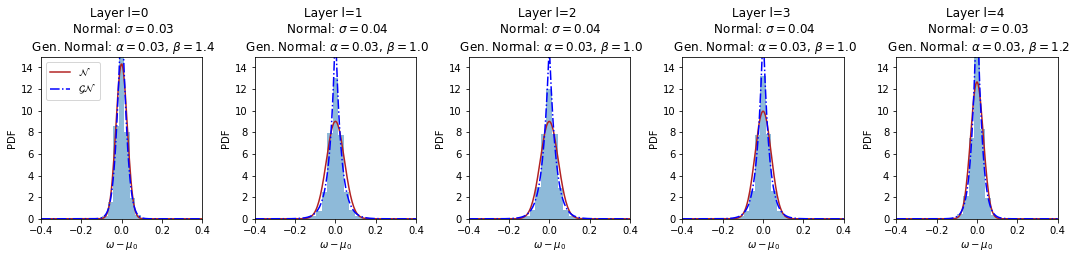

Prior 2
0.04622917 0.0018747145
0.087339096 0.008609995
0.0941982 0.007668375
0.09977155 0.009673434
0.08930352 0.0095918095


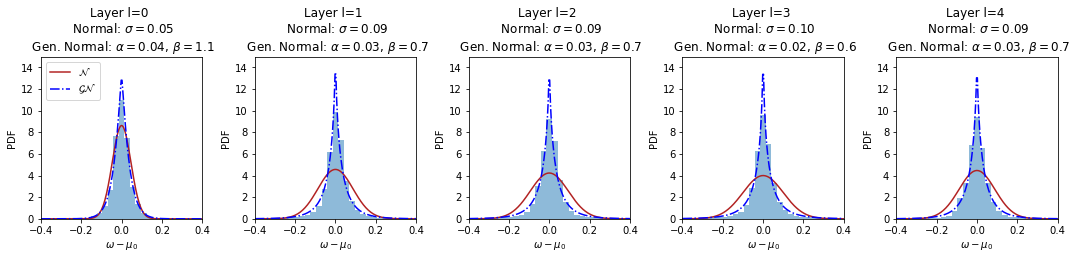

Prior 3
0.09848332 0.0045223557
0.23960225 0.055180077
0.24231237 0.043990724
0.29722852 0.06357932
0.36306944 0.12963055


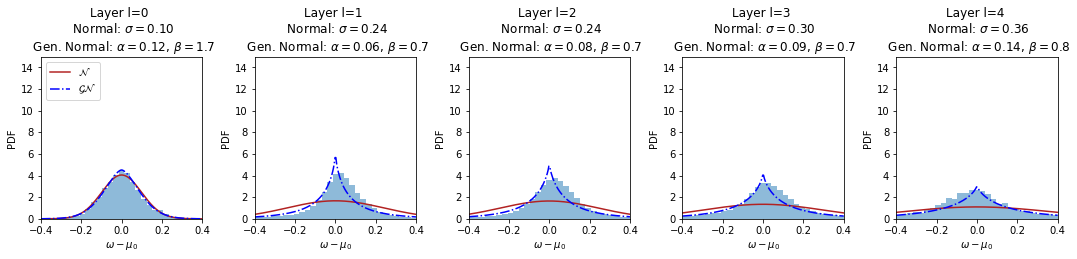

Prior 4
0.046274688 0.0011878269
0.095313385 0.0072585815
0.090850905 0.0052625826
0.09179855 0.004554107
0.08063555 0.0048866775


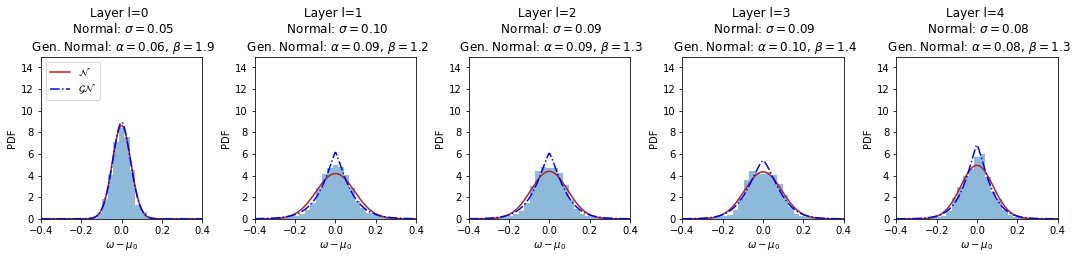

In [16]:
from scipy.stats import kurtosis, norm, t, uniform, gennorm

lims = [(-0.4, 0.4), (-0.4, 0.4), (-0.4, 0.4), (-0.4, 0.4), (-0.4, 0.4)]
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15, 3.7))
    print('Prior {}'.format(i+1))
    for j, w_ in enumerate(model):
        if j % 2 ==0:
            w_ = w_-np.mean(w_, axis=0)
            #w_ = w_-init_weights_for_all[j].reshape((-1,))    # NOPE
            var1, var2 = np.var(w_), np.var(np.var(w_, axis=0))
            print(np.sqrt(var1), np.sqrt(var2))
            w_ = w_.reshape((-1, ))
            nfit, gnfit = norm.fit(w_, floc=0), gennorm.fit(w_, floc=0)#, t.fit(w_, floc=0)
            #df = tfit[0]
            xx_ = np.linspace(lims[j//2][0], lims[j//2][1], 200)
            ax[j//2].hist(w_, density=True, bins=np.linspace(lims[j//2][0], lims[j//2][1], 30), alpha=0.5)
            ax[j//2].plot(xx_, norm(*nfit).pdf(xx_), color='firebrick', label=r'$\mathcal{N}$')
            ax[j//2].plot(xx_, gennorm(*gnfit).pdf(xx_), color='blue', label=r'$\mathcal{GN}$', 
                          linestyle='-.')
            #ax[j//2].plot(xx_, t(*tfit).pdf(xx_), color='blue', label=r'$t-St$', linestyle='-.')
            #log_pdfs = [np.sum(dist_(*params).logpdf(w_)) for dist_, params in 
            #            zip([t, gennorm], [tfit, gnfit])]
            #ax[i, j//2].set_title('df='+str(int(df))+', kurt={:.2f}'.format(kurt))
            #list_ = ['t-Student', 'Gen normal']
            lmda_norm = 1/(2*nfit[1]**2)
            lmda_gn, beta_gn = 1/(gnfit[2]**gnfit[0]), gnfit[0]
            #df_t = tfit[0]
            title = 'Layer l={} \n'.format(j//2)
            title += r' Normal: $\sigma={:.2f}$'.format(nfit[1])
            title += '\n'
            title += r' Gen. Normal: $\alpha={:.2f}$, $\beta={:.1f}$'.format(gnfit[2], gnfit[0])
            #if lmda_gn>1000:
            #    title += r' Gen. Normal: $\lambda>1000$, $\beta={:.1f}$'.format(beta_gn)
            #else:
            #    title += r' Gen. Normal: $\lambda={}$, $\beta={:.1f}$'.format(int(lmda_gn), beta_gn)
            #title += r't-Student: df=${}$'.format(int(df_t))
            ax[j//2].set_title(title)
            ax[j//2].set_xlabel('$\omega-\mu_0$')
            ax[j//2].set_ylabel('PDF')
            ax[j//2].set_xlim(lims[j//2])
            ax[j//2].set_ylim([0, 15])
            #ax[j//2].legend(loc='upper right')
    ax[0].legend(loc='upper left')
    fig.tight_layout()
    plt.show()

0.0018498572
0.008683831
0.066839725
0.008486685


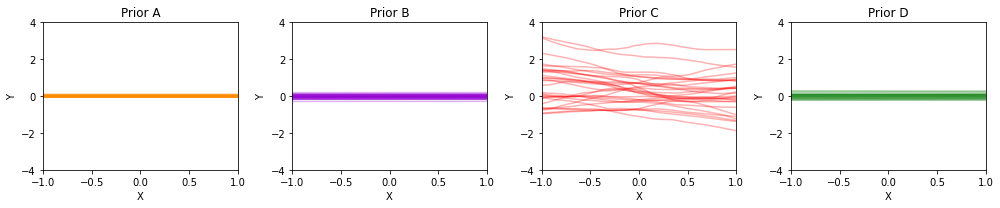

In [17]:
# Gaussian zero mean
tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
curr_weights = tmp_model.get_weights()
x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
n_to_plot = 30

fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    all_weights = np.concatenate(model, axis=1)
    global_var = np.mean(np.var(all_weights, axis=0))
    print(global_var)
    sampled_weights = []
    for j, w_ in enumerate(model):      
        sampled_w = norm(loc=0, scale=np.sqrt(global_var)).rvs((n_to_plot, ) + curr_weights[j].shape)
        sampled_weights.append(sampled_w)

    for n in range(n_to_plot):
        curr_weights = [w_[n] for w_ in sampled_weights]
        tmp_model.set_weights(curr_weights)
        ax[i].plot(x_values, tmp_model.predict(x_values, verbose=False), color=prior_colors[i], alpha=0.3)
ax = set_some_stuff_prior(ax)
fig.tight_layout()
plt.show()

Prior 1
[0.001 0.003 0.002 0.003 0.002 0.003 0.002 0.002 0.001 0.004]
Prior 2
[0.002 0.006 0.008 0.007 0.009 0.005 0.01  0.003 0.008 0.003]
Prior 3
[0.01  0.011 0.057 0.025 0.059 0.017 0.088 0.01  0.132 0.009]
Prior 4
[0.002 0.009 0.009 0.008 0.008 0.006 0.008 0.004 0.007 0.001]


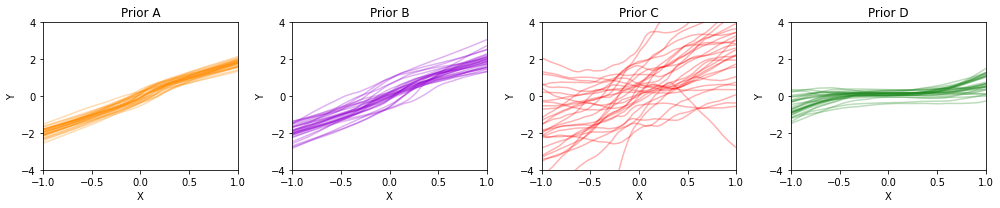

In [18]:
# Gaussian same variance every where
tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
curr_weights = tmp_model.get_weights()
x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
n_to_plot = 30

fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    sampled_weights = []
    params = []
    for j, w_ in enumerate(model):
        w0 = np.mean(w_, axis=0, keepdims=True)
        #var_ = np.var((w_-w0).reshape((-1,)))
        var_ = np.mean(np.var(w_-w0, axis=0))
        #print(np.mean(np.var(w_-w0, axis=0)), np.var((w_-w0).reshape((-1,))))
        params.append(var_)
        sampled_w = norm(loc=w0, scale=np.sqrt(var_)).rvs((n_to_plot, ) + w0.shape)
        sampled_weights.append(sampled_w.reshape((n_to_plot, ) + curr_weights[j].shape))
    for n in range(n_to_plot):
        curr_weights = [w_[n] for w_ in sampled_weights]
        tmp_model.set_weights(curr_weights)
        ax[i].plot(x_values, tmp_model.predict(x_values, verbose=False), color=prior_colors[i], alpha=0.3)
    print('Prior {}'.format(i+1))
    print(np.around(params,3))
ax = set_some_stuff_prior(ax)
fig.tight_layout()
plt.show()


Prior 1
[1.352 1.175 0.964 1.234 1.041 1.484 1.044 1.854 1.153 3.878]
Prior 2
[1.14  1.387 0.713 1.077 0.696 1.237 0.643 1.432 0.726 2.302]
Prior 3
[1.653 1.365 0.685 1.384 0.743 1.379 0.717 1.495 0.757 1.347]
Prior 4
[1.871 1.175 1.195 1.445 1.278 1.575 1.449 1.914 1.278 2.044]


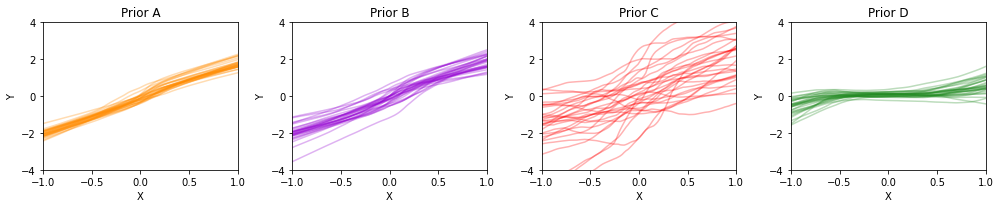

In [19]:
# Gen Gaussian
fig, ax = plt.subplots(ncols=4, figsize=(14, 3))
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    sampled_weights = []
    params = []
    for j, w_ in enumerate(model):
        w0 = np.mean(w_, axis=0, keepdims=True)
        gnfit = gennorm.fit((w_-w0).reshape((-1,)), floc=0)
        params.append(gnfit[0])
        sampled_w = w0 + gennorm(*gnfit).rvs((n_to_plot, ) + w0.shape)
        sampled_weights.append(sampled_w.reshape((n_to_plot, ) + curr_weights[j].shape))
    for n in range(n_to_plot):
        curr_weights = [w_[n] for w_ in sampled_weights]
        tmp_model.set_weights(curr_weights)
        ax[i].plot(x_values, tmp_model.predict(x_values, verbose=False), color=prior_colors[i], alpha=0.3)
    print('Prior {}'.format(i+1))
    print(np.around(params,3))
ax = set_some_stuff_prior(ax)
fig.tight_layout()
plt.show()

### Look at correlations

Prior 1


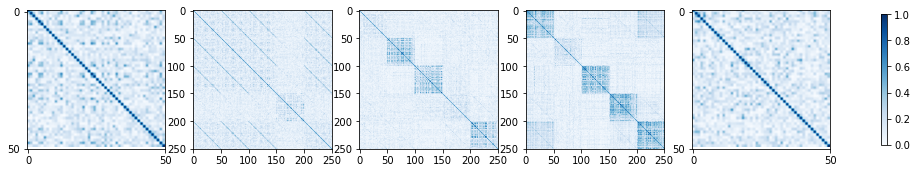

Prior 2


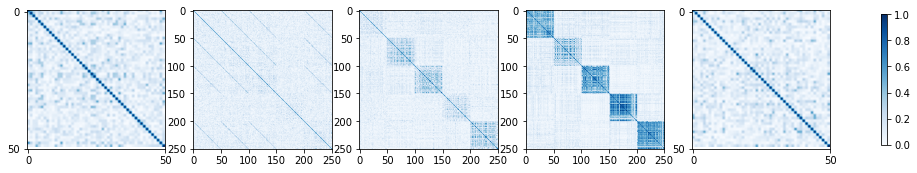

Prior 3


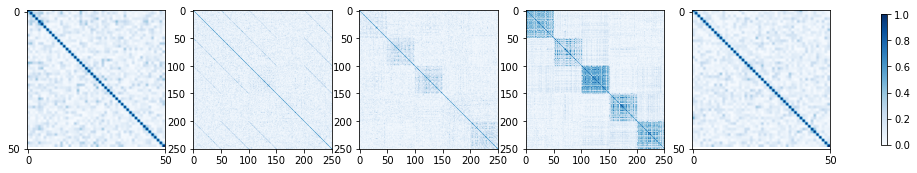

Prior 4


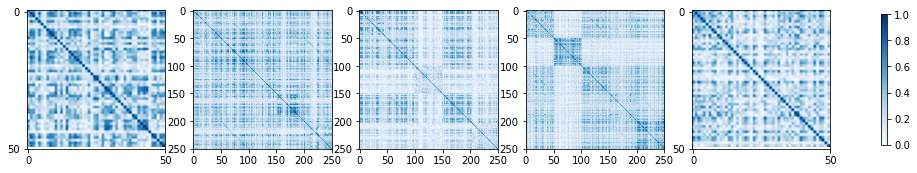

In [20]:
from scipy.linalg import svd, block_diag
from scipy.stats import multivariate_normal


def compute_cross_from_svd(weights_from_ens, n_to_sample):
    N_, d_ = weights_from_ens.shape
    w0 = np.mean(weights_from_ens, axis=0)
    weights_from_ens = (weights_from_ens-w0)/np.std(weights_from_ens, axis=0)
    Uh, S, Vh = svd(weights_from_ens, full_matrices=False)
    #print(Uh.shape, S.shape, Vh.shape)
    cov_chol = 1/np.sqrt(N_-1) * np.multiply(S[:-1,None], Vh[:-1,...]).T
    return cov_chol


for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    print('Prior {}'.format(i+1))

    n_ens = model[0].shape[0]
    all_concat = model[0].reshape((n_ens, -1))
    #print(all_concat.shape[1])
    for j, w_ in enumerate(model):
        if j % 2 == 0 and j >= 1:
            all_concat = np.concatenate([all_concat, w_.reshape((n_ens, -1))], axis=1)
            #print(all_concat.shape[1])
    
    # direct computation
    #corr = np.corrcoef(all_concat, rowvar=False)
    #corr = np.nan_to_num(corr, copy=False)    # set nan corrs to 0
    # from svd
    cov_chol = compute_cross_from_svd(all_concat.reshape((n_ens, -1)), 2)
    #print(cov_chol.shape)
    corr = np.matmul(cov_chol, cov_chol.T)
    
    n_to_see = 250
    fig, ax = plt.subplots(ncols=5, figsize=(18, 6))
    b_ = ax[0].imshow(np.abs(corr[:50, :50]), vmin=0, vmax=1, cmap='Blues')
    b_ = ax[1].imshow(np.abs(corr[50:50+n_to_see, 50:50+n_to_see]), vmin=0, vmax=1, cmap='Blues')
    b_ = ax[2].imshow(np.abs(corr[2550:2550+n_to_see, 2550:2550+n_to_see]), vmin=0, vmax=1, cmap='Blues')
    b_ = ax[3].imshow(np.abs(corr[5050:5050+n_to_see, 5050:5050+n_to_see]), vmin=0, vmax=1, cmap='Blues')
    b_ = ax[4].imshow(np.abs(corr[7550:,7550:]), vmin=0, vmax=1, cmap='Blues')
    plt.colorbar(b_, ax=ax, shrink=0.4)
    for j in [0, 4]:
        ax[j].set_xticks([0, 50])
        ax[j].set_yticks([0, 50])
    for j in [1, 2, 3]:
        ax[j].set_xticks([0, 50, 100, 150, 200, 250])
        ax[j].set_yticks([0, 50, 100, 150, 200, 250])
    #fig.tight_layout()
    plt.show()

Prior 1


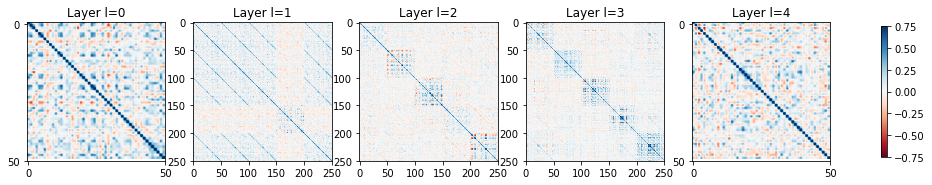

Prior 2


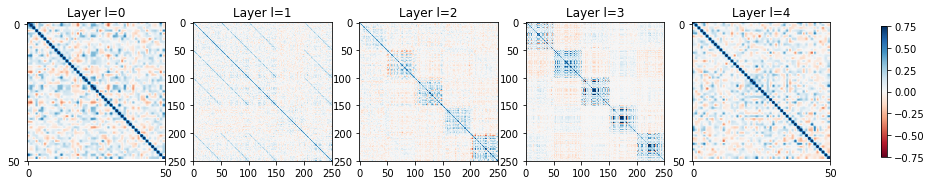

Prior 3


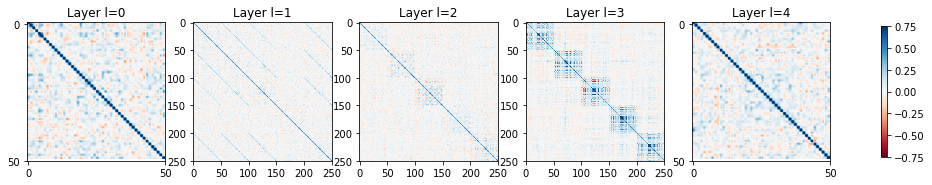

Prior 4


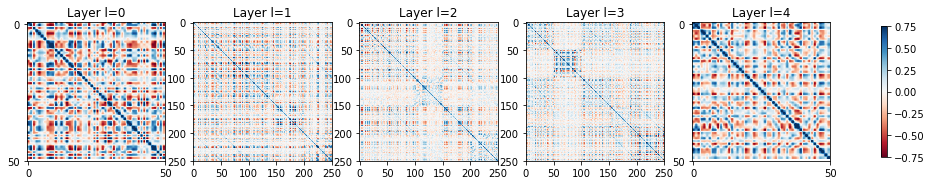

In [23]:
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    print('Prior {}'.format(i+1))

    n_ens = model[0].shape[0]
    all_concat = model[0].reshape((n_ens, -1))
    #print(all_concat.shape[1])
    for j, w_ in enumerate(model):
        if j % 2 == 0 and j >= 1:
            all_concat = np.concatenate([all_concat, w_.reshape((n_ens, -1))], axis=1)
            #print(all_concat.shape[1])
    
    # direct computation
    #corr = np.corrcoef(all_concat, rowvar=False)
    #corr = np.nan_to_num(corr, copy=False)    # set nan corrs to 0
    # from svd
    cov_chol = compute_cross_from_svd(all_concat.reshape((n_ens, -1)), 2)
    #print(cov_chol.shape)
    corr = np.matmul(cov_chol, cov_chol.T)
    
    n_to_see = 250
    fig, ax = plt.subplots(ncols=5, figsize=(18, 6))
    b_ = ax[0].imshow(corr[:50, :50], vmin=-0.75, vmax=0.75, cmap='RdBu')
    b_ = ax[1].imshow(corr[50:50+n_to_see, 50:50+n_to_see], vmin=-0.75, vmax=0.75, cmap='RdBu')
    b_ = ax[2].imshow(corr[2550:2550+n_to_see, 2550:2550+n_to_see], vmin=-0.75, vmax=0.75, cmap='RdBu')
    b_ = ax[3].imshow(corr[5050:5050+n_to_see, 5050:5050+n_to_see], vmin=-0.75, vmax=0.75, cmap='RdBu')
    b_ = ax[4].imshow(corr[7550:,7550:], vmin=-0.75, vmax=0.75, cmap='RdBu')
    plt.colorbar(b_, ax=ax, shrink=0.4)
    for j in [0, 4]:
        ax[j].set_xticks([0, 50])
        ax[j].set_yticks([0, 50])
    for j in [1, 2, 3]:
        ax[j].set_xticks([0, 50, 100, 150, 200, 250])
        ax[j].set_yticks([0, 50, 100, 150, 200, 250])
    #fig.tight_layout()
    for j in range(5):
        ax[j].set_title('Layer l={}'.format(j))
    plt.show()

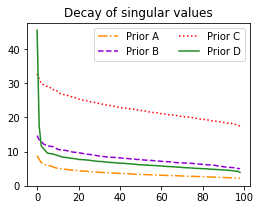

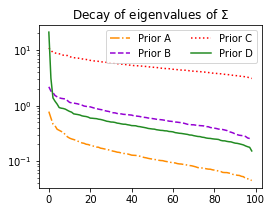

In [25]:
from scipy.linalg import svd, block_diag
from scipy.stats import multivariate_normal

def compute_svd(weights_from_ens):
    N_, d_ = weights_from_ens.shape
    w0 = np.mean(weights_from_ens, axis=0)
    _, S, Vh = svd(weights_from_ens - w0, full_matrices=False)
    return S[:-1]

tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
curr_weights = tmp_model.get_weights()
x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
fig, ax = plt.subplots(ncols=1, figsize=(4, 3))
linestyles = ['-.', '--', ':', '-']
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    n_ens = model[0].shape[0]
    all_concat = model[0].reshape((n_ens, -1))
    for j, w_ in enumerate(model[1:]):
        all_concat = np.concatenate([all_concat, w_.reshape((n_ens, -1))], axis=1)
    sing_values = compute_svd(all_concat.reshape((n_ens, -1)))
    
    ax.plot(sing_values, color=prior_colors[i], linestyle=linestyles[i], label='Prior {}'.format(prior_names[i]))
    ax.set_title('Decay of singular values')
ax.legend(ncol=2, loc='upper right')
#fig.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=1, figsize=(4, 3))
for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    n_ens = model[0].shape[0]
    all_concat = model[0].reshape((n_ens, -1))
    for j, w_ in enumerate(model[1:]):
        all_concat = np.concatenate([all_concat, w_.reshape((n_ens, -1))], axis=1)
    sing_values = compute_svd(all_concat.reshape((n_ens, -1)))
    eigen_values = sing_values**2/(n_ens-1)
    
    ax.plot(eigen_values, color=prior_colors[i], linestyle=linestyles[i], label='Prior {}'.format(prior_names[i]))
    ax.set_title('Decay of eigenvalues of $\Sigma$')
ax.legend(ncol=2, loc='upper right')
ax.set_yscale('log')
plt.show()

Prior 1
Prior 2
Prior 3
Prior 4


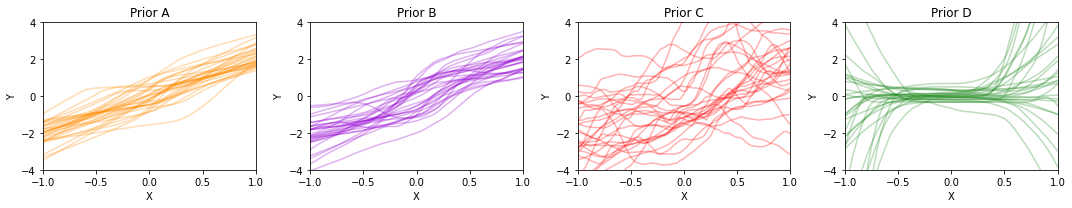

In [29]:
from scipy.linalg import svd, block_diag
from scipy.stats import multivariate_normal

def sample_from_multivariate_gauss_v4(weights_from_ens, n_to_sample):
    N_, d_ = weights_from_ens.shape
    w0 = np.mean(weights_from_ens, axis=0)
    #var_ = np.mean(np.var(weights_from_ens-w0, axis=0))
    #var_ = np.var((weights_from_ens-w0).reshape((-1,)))
    #print(np.mean(np.var(weights_from_ens-w0, axis=0)), np.var((weights_from_ens-w0)))
    _, S, Vh = svd(weights_from_ens-w0, full_matrices=False)
    cov_chol = 1/np.sqrt(N_-1) * np.multiply(S[:-1,None], Vh[:-1,...]).T
    rvs = np.matmul(cov_chol, np.random.randn(cov_chol.shape[1], n_to_sample))
    return w0[np.newaxis, ...] + rvs.T

tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
curr_weights = tmp_model.get_weights()
x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
fig, ax = plt.subplots(ncols=4, figsize=(15, 3))
n_to_plot = 30

for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    n_ens = model[0].shape[0]
    all_concat = model[0].reshape((n_ens, -1))
    for j, w_ in enumerate(model[1:]):
        all_concat = np.concatenate([all_concat, w_.reshape((n_ens, -1))], axis=1)
    sampled_w = sample_from_multivariate_gauss_v4(all_concat.reshape((n_ens, -1)), n_to_plot)
    sampled_weights = []
    nc = 0
    for j, w_ in enumerate(model):
        sampled_weights.append(sampled_w[:, nc:nc+curr_weights[j].size].reshape(
            (n_to_plot, ) + curr_weights[j].shape))
        nc += curr_weights[j].size
        
    for n in range(n_to_plot):
        curr_weights = [w_[n] for w_ in sampled_weights]
        tmp_model.set_weights(curr_weights)
        ax[i].plot(x_values, tmp_model.predict(x_values, verbose=False), color=prior_colors[i], alpha=0.3)
    print('Prior {}'.format(i+1))
ax = set_some_stuff_prior(ax)
fig.tight_layout()
plt.show()


Prior 1
Prior 2
Prior 3
Prior 4


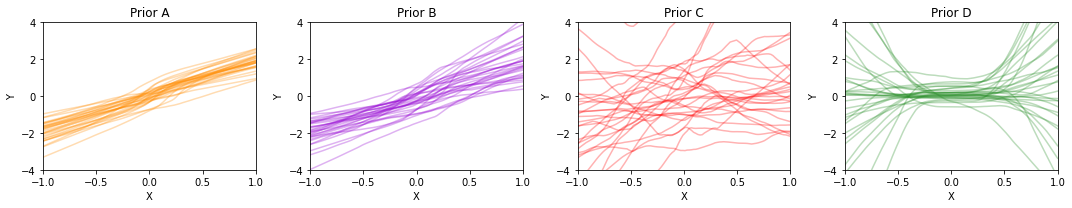

In [27]:
# this one only considers correlation within a layer, not accross layers
from scipy.linalg import svd, block_diag
from scipy.stats import multivariate_normal

def sample_from_multivariate_gauss_v4(weights_from_ens, n_to_sample):
    N_, d_ = weights_from_ens.shape
    w0 = np.mean(weights_from_ens, axis=0)
    #var_ = np.mean(np.var(weights_from_ens-w0, axis=0))
    #var_ = np.var((weights_from_ens-w0).reshape((-1,)))
    #print(np.mean(np.var(weights_from_ens-w0, axis=0)), np.var((weights_from_ens-w0)))
    _, S, Vh = svd(weights_from_ens - w0, full_matrices=False)
    cov_chol = 1/np.sqrt(N_-1) * np.multiply(S[:-1,None], Vh[:-1,...]).T
    rvs = np.matmul(cov_chol, np.random.randn(cov_chol.shape[1], n_to_sample))
    return w0[np.newaxis, ...] + rvs.T

tmp_model = create_nn_per_layer(layers_shape=layers_shape, act=act, lmda_reg=0.)
curr_weights = tmp_model.get_weights()
x_values = np.linspace(-1, 1, 100).reshape((-1, 1))
fig, ax = plt.subplots(ncols=4, figsize=(15, 3))
n_to_plot = 30

for i, model in enumerate([all_ws_v0, all_ws_v1, all_ws_v2, all_ws_v3]):
    n_ens = model[0].shape[0]
    sampled_weights = []
    for j, w_ in enumerate(model):
        sampled_w = sample_from_multivariate_gauss_v4(w_.reshape((n_ens, -1)), n_to_plot)
        sampled_weights.append(sampled_w.reshape((n_to_plot, ) + curr_weights[j].shape))
        
    for n in range(n_to_plot):
        curr_weights = [w_[n] for w_ in sampled_weights]
        tmp_model.set_weights(curr_weights)
        ax[i].plot(x_values, tmp_model.predict(x_values, verbose=False), color=prior_colors[i], alpha=0.3)
    print('Prior {}'.format(i+1))
ax = set_some_stuff_prior(ax)
fig.tight_layout()
plt.show()